In [1]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from sklearn.preprocessing import RobustScaler
plt.style.use("bmh")

# Technical Analysis library
import ta

# Neural Network library
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Loading in the Data
df = pd.read_csv("AAPL.csv")

In [2]:
%pip install ta

Defaulting to user installation because normal site-packages is not writeable
  Created wheel for ta: filename=ta-0.7.0-py3-none-any.whl size=28717 sha256=51f9a076565117bea748c1f7b65978d494c052a7bc05fbc2f3a4f659c73238a0
  Stored in directory: /home/jl057/.cache/pip/wheels/5e/74/e0/72395003bd1d3c8f3f5860c2d180ff15699e47a2733d8ebd38
Successfully built ta
Note: you may need to restart the kernel to use updated packages.


In [3]:
## Datetime conversion
df['Date'] = pd.to_datetime(df.Date)

# Setting the index
df.set_index('Date', inplace=True)

# Dropping any NaNs
df.dropna(inplace=True)



## Technical Indicators

# Adding all the indicators
df = ta.add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

# Dropping everything else besides 'Close' and the Indicators
df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)

# Only using the last 1000 days of data to get a more accurate representation of the current market climate
df = df.tail(1000)



## Scaling

# Scale fitting the close prices separately for inverse_transformations purposes later
close_scaler = RobustScaler()

close_scaler.fit(df[['Close']])

# Normalizing/Scaling the DF
scaler = RobustScaler()

df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

AttributeError: 'DataFrame' object has no attribute 'Date'

In [4]:
df.head()

,Close,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,volume_nvi,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-13,-1.564782,-2.146048,-1.626505,4.567587,-0.242469,-0.169383,-0.096075,-0.340734,-10.813942,-0.756398,...,0.435042,-0.443823,-1.513657,-0.394869,0.072748,-0.010231,0.056670,-15.325945,-0.067552,-1.564782
2020-04-14,-1.452331,-1.935552,-1.529968,4.183968,5.022674,2.448557,0.805562,3.216072,-8.740860,-0.756398,...,0.442116,-0.443823,-1.486431,-0.394869,0.434190,0.077075,0.618588,1.953815,1.916025,-1.452331
2020-04-15,-1.473680,-1.873838,-1.594899,3.453693,4.174462,0.345946,-0.077606,1.474098,1.761327,-0.776672,...,0.216018,-0.443823,-1.471950,-0.394869,0.353258,0.127371,0.380384,-0.432455,-0.436704,-1.473680
2020-04-16,-1.455264,-1.766537,-1.517111,3.193438,3.642730,1.032087,-0.010013,0.982321,-0.090776,-0.776672,...,0.411050,-0.443823,-1.456012,-0.394869,0.428818,0.185859,0.433110,0.250769,0.251080,-1.455264
2020-04-17,-1.486962,-1.712633,-1.623675,2.575355,2.853653,-0.137718,-0.299506,0.450932,-0.461994,-0.776672,...,0.075353,-0.443823,-1.451604,-0.394869,0.781920,0.317941,0.906775,-0.610190,-0.617568,-1.486962


In [5]:
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the multivariate time sequence
    """
    
    # Creating a list for both variables
    X, y = [], []
    
    for i in range(len(seq)):
        
        # Finding the end of the current sequence
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        # Breaking out of the loop if we have exceeded the dataset's length
        if out_end > len(seq):
            break
        
        # Splitting the sequences into: x = past prices and indicators, y = prices ahead
        seq_x, seq_y = seq[i:end, :], seq[end:out_end, 0]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)
  
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(16,5))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(16,5))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    
def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Creates a specified number of hidden layers for an RNN
    Optional: Adds regularization option - the dropout layer to prevent potential overfitting (if necessary)
    """
    
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass
          
def validater(n_per_in, n_per_out):
    """
    Runs a 'For' loop to iterate through the length of the DF and create predicted values for every stated interval
    Returns a DF containing the predicted values for the model with the corresponding index values based on a business day frequency
    """
    
    # Creating an empty DF to store the predictions
    predictions = pd.DataFrame(index=df.index, columns=[df.columns[0]])

    for i in range(n_per_in, len(df)-n_per_in, n_per_out):
        # Creating rolling intervals to predict off of
        x = df[-i - n_per_in:-i]

        # Predicting using rolling intervals
        yhat = model.predict(np.array(x).reshape(1, n_per_in, n_features))

        # Transforming values back to their normal prices
        yhat = close_scaler.inverse_transform(yhat)[0]

        # DF to store the values and append later, frequency uses business days
        pred_df = pd.DataFrame(yhat, 
                               index=pd.date_range(start=x.index[-1], 
                                                   periods=len(yhat), 
                                                   freq="B"),
                               columns=[x.columns[0]])

        # Updating the predictions DF
        predictions.update(pred_df)
        
    return predictions


def val_rmse(df1, df2):
    """
    Calculates the root mean square error between the two Dataframes
    """
    df = df1.copy()
    
    # Adding a new column with the closing prices from the second DF
    df['close2'] = df2.Close
    
    # Dropping the NaN values
    df.dropna(inplace=True)
    
    # Adding another column containing the difference between the two DFs' closing prices
    df['diff'] = df.Close - df.close2
    
    # Squaring the difference and getting the mean
    rms = (df[['diff']]**2).mean()
    
    # Returning the sqaure root of the root mean square
    return float(np.sqrt(rms))

In [6]:
# How many periods looking back to learn
n_per_in  = 90
# How many periods to predict
n_per_out = 30
# Features 
n_features = df.shape[1]
# Splitting the data into appropriate sequences
X, y = split_sequence(df.to_numpy(), n_per_in, n_per_out)

In [7]:
## Creating the NN

# Instatiating the model
model = Sequential()

# Activation
activ = "tanh"

# Input layer
model.add(LSTM(90, 
               activation=activ, 
               return_sequences=True, 
               input_shape=(n_per_in, n_features)))

# Hidden layers
layer_maker(n_layers=1, 
            n_nodes=30, 
            activation=activ)

# Final Hidden layer
model.add(LSTM(60, activation=activ))

# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()

# Compiling the data with selected specifications
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

## Fitting and Training
res = model.fit(X, y, epochs=50, batch_size=128, validation_split=0.1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90, 90)            63000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 90, 30)            14520     
_________________________________________________________________
lstm_2 (LSTM)                (None, 60)                21840     
_________________________________________________________________
dense (Dense)                (None, 30)                1830      
Total params: 101,190
Trainable params: 101,190
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1/1 [==============================] - 1s 534ms/step - loss: 0.1425 - accuracy: 0.0254 - val_loss: 0.0701 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 18ms/step - loss: 0.1280 - accuracy: 0.0424 - val_l

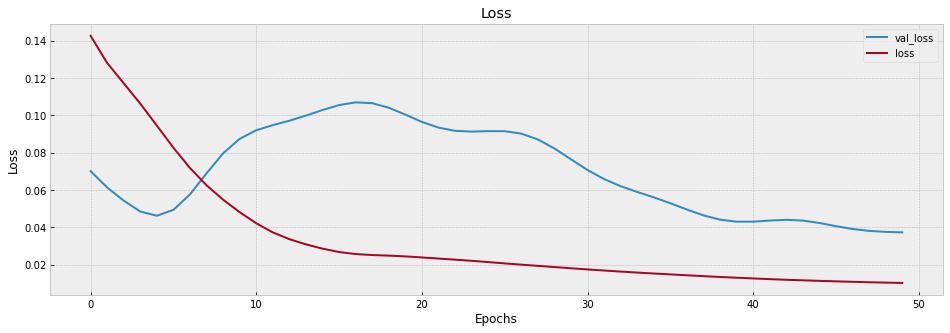

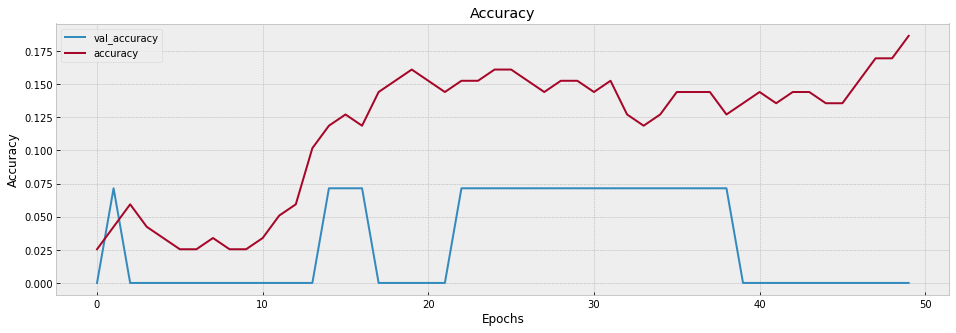

In [8]:
visualize_training_results(res)

RMSE: 2.959823810747546


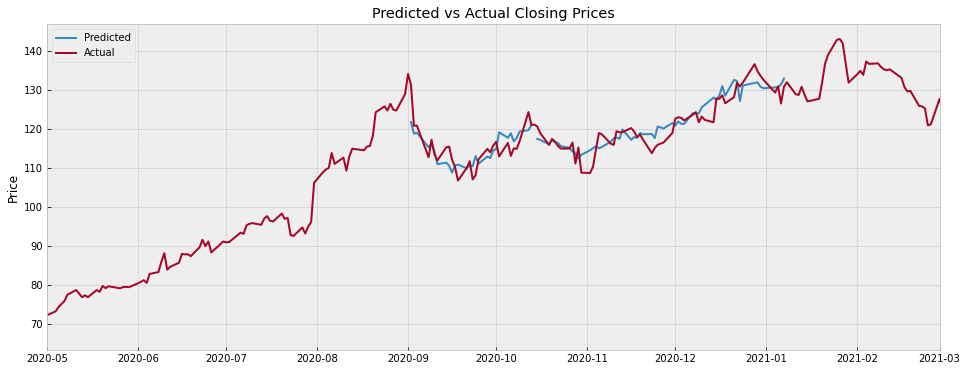

In [11]:
# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["Close"]]), 
                      index=df.index, 
                      columns=[df.columns[0]])

# Getting a DF of the predicted values to validate against
predictions = validater(n_per_in, n_per_out)

# Printing the RMSE
print("RMSE:", val_rmse(actual, predictions))
    
# Plotting
plt.figure(figsize=(16,6))

# Plotting those predictions
plt.plot(predictions, label='Predicted')

# Plotting the actual values
plt.plot(actual, label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
plt.xlim('2020-05', '2021-03')
plt.show()

                 Close
2021-04-12  119.425705
2021-04-13  118.801743
2021-04-14  117.941643
2021-04-15  119.361252
2021-04-16  119.432991
2021-04-19  121.229500
2021-04-20  120.961418
2021-04-21  117.795837
2021-04-22  122.231979
2021-04-23  120.661880
2021-04-26  120.613777
2021-04-27  118.832603
2021-04-28  121.013092
2021-04-29  125.041679
2021-04-30  120.800720
2021-05-03  123.120972
2021-05-04  124.240906
2021-05-05  124.484352
2021-05-06  127.827782
2021-05-07  124.854057
2021-05-10  129.835419
2021-05-11  127.819992
2021-05-12  128.256378
2021-05-13  127.715652
2021-05-14  129.029022
2021-05-17  128.311371
2021-05-18  128.489059
2021-05-19  128.650238
2021-05-20  129.316055
2021-05-21  131.957947


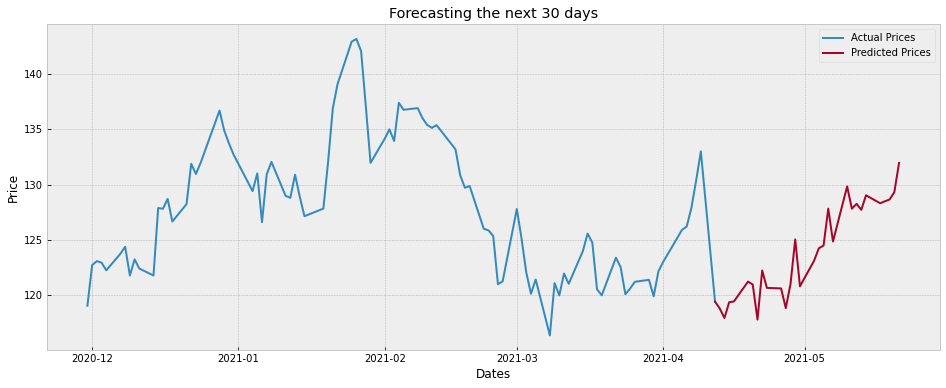

In [10]:
# Predicting off of the most recent days from the original DF
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features))

# Transforming the predicted values back to their original format
yhat = close_scaler.inverse_transform(yhat)[0]

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, 
                     index=pd.date_range(start=df.index[-1]+timedelta(days=1), 
                                         periods=len(yhat), 
                                         freq="B"), 
                     columns=[df.columns[0]])

# Number of periods back to plot the actual values
pers = n_per_in

# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["Close"]].tail(pers)), 
                      index=df.Close.tail(pers).index, 
                      columns=[df.columns[0]]).append(preds.head(1))

# Printing the predicted prices
print(preds)

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
plt.show()